$$ \textbf{Практичесское задание 2} $$
$$ \textbf{Богданов Александр} $$

Рассмотрим задачу построения коллажа из $K$ фотографий $y_1, \dots ,y_K \in A^{M \times N}$, где $A$ есть множество значений пикселей. Задача построения коллажа состоит в поиске матрицы $x \in [K]^{M \times N}$, которая для каждого пикселя указывает, из какого изображения его следует взять.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import networkx as nx
from PIL import Image

$\textbf{а)}$ Сделать несколько фотографий одинакового размера $M \times N$ для построения коллажа. (10 баллов)

In [2]:
# получение небольших по размеру картинок 
def get_paths(n, path="", size=800):
    pictures_paths = [f"pictures{path}/picture_" + str(i + 1) + ".JPG" for i in range(n)]
    for i, picture_path in enumerate(pictures_paths):
        image = Image.open(picture_path)
        image.thumbnail((size, size))
        image.save(f"pictures_resize{path}/picture_" + str(i + 1) + ".JPG")
    return [f"pictures_resize{path}/picture_" + str(i + 1) + ".JPG" for i in range(n)]

In [3]:
# отрисовка картинок
def plot_pictures(pictures_paths):
    plt.figure(figsize=(16,5))
    for i in range(len(pictures_paths)):
        plt.subplot(1, len(pictures_paths), i + 1)
        plt.imshow(plt.imread(pictures_paths[i]))
        plt.title(f"picture {i + 1}") 
    plt.show()

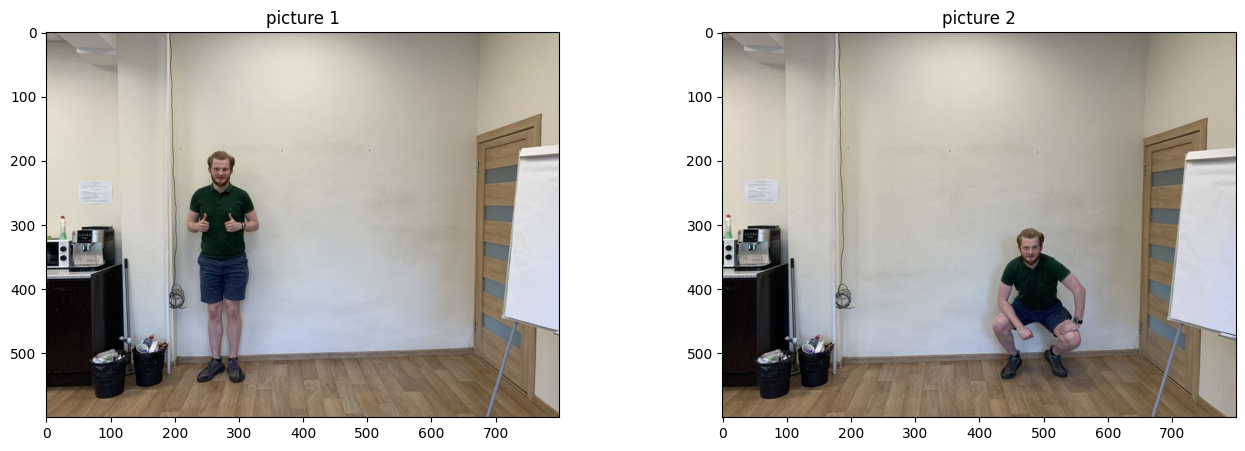

In [4]:
# Фотографии для GraphCut
pictures_paths_cut = get_paths(2, path="/GraphCut")
plot_pictures(pictures_paths_cut)

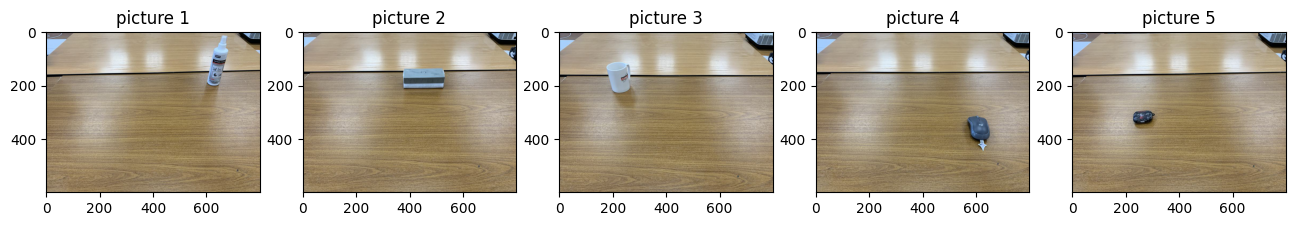

In [5]:
# Фотографии для альфа-расширения
pictures_paths_alpha = get_paths(5, path="/Alpha")
plot_pictures(pictures_paths_alpha)

$\textbf{б)}$ Рассмотреть задачу построения коллажа из $K = 2$ изображений с парносепарабельной энергией $E(x) = \theta_0 + \sum\limits_i θ_i (x_i) + \sum\limits_{(i, j) \in \varepsilon} θ_{ij} (x_i, x_j)$.

1. Выбрать систему соседства $\varepsilon$ и вид унарных и парных потенциалов $θ_i, θ_{ij}$. (8 баллов)
    
2. Описать, как выбранные потенциалы отражают цель построить правдоподобный для человеческого глаза коллаж. (7 баллов)

3. Как выбрать потенциалы $θ_i (x_i)$, чтобы указать, что некоторые части коллажа стоит брать из определенного изображения? (5 баллов)
 
4. Как функция энергии $E(x)$ связана с вероятностью появления коллажа p(x)? (5 баллов)

1. $\textbf{Систем соседства}$ возможно два: крестом, квадратом - посмотрим на практике, что работает лучше (если каких-то координат нет, то не будем их добавлять).

   $\textbf{Вид унитарных потенциалов}$: В выделенных пикселях $\theta_i (x_i) = + \infty$ - это те пиксели, которые мы гарантированно не берем. В остальных пикселях $\theta_i (x_i) = 0$.

   $\textbf{Вид парных потенциалов}$: Возможно два варианта:
   
   а) Потенциал с лекции без минуса в экспоненте:
   
   $$\theta_{ij}(x_i, x_j) = [x_i \neq x_j] \cdot \exp \left( \frac{ \|y_{x_i, i} - y_{x_j, j}\|_2^2}{2 \sigma^2} \right)$$

   б) Потенциал с ограниченными пределами:
   
   $$\theta_{ij}(x_i, x_j) = [x_i \neq x_j] \cdot \tanh \left( \|y_{x_i, i} - y_{x_j, j}\|_2^2 \right)$$

2. Унарные потенциалы с помощью бесконечных потенциалов заставляет алгоритм выбирать определенные части различных картинок. А парные потенциалы при выборе соседей из одной и той же картинки равны нулю, иначе мы их считаем и охотнее выбираем те ребра, в которых переход плавнее, что заставляет алгоритм достраивать пиксели, помеченные бесконечностью.

3. Выделим пиксели $\theta_i (x_i) = + \infty$ - это те пиксели, которые мы гарантированно не берем (следовательно из другой картинки мы эти пиксели гарантировано возьмем). В остальных пикселях $\theta_i (x_i) = 0$.

4. Решается задача оптимизации:

   $$ p(\mathbf{x}|\mathbf{y}) \to \max_{\mathbf{x}} \equiv p(\mathbf{x}, \mathbf{y}) \to \max_{\mathbf{x}}$$

   $p(\mathbf{x}, \mathbf{y})$ представима в виде:
   
   $$ p(\mathbf{x}, \mathbf{y}) = \psi_0 \prod_{(i, j) \in \varepsilon} \psi_{ij}(x_i, x_j) \prod_{i} \psi_{i}(x_i, y_i)$$
   
   Можно ввести энергию, таким образом:
   
   $$ p(\mathbf{x}, \mathbf{y}) = \frac{1}{Z} e^{-E(\mathbf{x}, \mathbf{y})},\ \text{где}\ Z - \text{нормировочная константа} $$
   
   И переписать ее так:
   
   $$ E(\mathbf{x}, \mathbf{y}) = - \log \psi_0 - \sum_{(i, j) \in \varepsilon} \log \psi_{ij}(x_i, x_j) - \sum_{i} \log \psi_{i}(x_i, y_i) + Сonst$$
    
   Тогда задачу оптимизации можно переписать в виде:
   
   $$ E(\mathbf{x}, \mathbf{y}) \to \min_{\mathbf{x}} \equiv \tilde{E}(\mathbf{x}) = \theta_0 + \sum_i \theta_i(x_i) + \sum_{(i, j) \in \varepsilon} \theta_{ij}(x_i, x_j) \to \min_{\mathbf{x}}$$

$\textbf{в)}$ Какими свойствами обладают выбранные потенциалы, являются ли они субмодулярными? Если условие субмодулярности невыполнено, модифицируйте потенциалы для его выполнения. (10 баллов)

Потенциалы субмодулярными, если:

$$\theta_{ij}(0, 1) + \theta_{ij}(1, 0) \geqslant \theta_{ij}(0, 0) + \theta_{ij}(1, 1)$$

В нашем случае:

$$\theta_{ij}(0, 1) + \theta_{ij}(1, 0) \geqslant \theta_{ij}(0, 0) + \theta_{ij}(1, 1) = 0$$

В силу того, что: 

$$\theta_{ij}(0, 1) \geqslant 0,  \theta_{ij}(1, 0) \geqslant 0$$

$\textbf{г)}$
1. Реализовать алгоритм на основе разрезов графов (GraphCut) для поиска наиболее вероятной конфигурации $\textbf{x}^*$ в графической модели, заданной выбранной энергией $E(x)$:

$$\textbf{x}^* = \arg \min E(x) = \arg \min \sum_i θ_i (x_i) + \sum_{(i, j) \in \varepsilon} θ_{ij} (x_i, x_j).\ \text{(35 баллов)}$$

2. Привести и описать полученный коллаж, мофицировать потенциалы для получения более правдоподобного коллажа (10 баллов);

In [6]:
def get_neighbours(shape, node, neighbour_type="square"):
        
    square_mask = [(-1, -1), (-1, 0), (-1, 1), 
                    (0, -1),           (0, 1), 
                    (1, -1),  (1, 0),  (1, 1)]
    
    сross_mask = [        (-1, 0),  
                  (0, -1),        (0, 1), 
                          (1, 0)        ]
    
    if neighbour_type == "square":
        mask = [
            (-1, -1), (-1, 0), (-1, 1), 
            (0, -1),           (0, 1), 
            (1, -1),  (1, 0),  (1, 1)
        ]
    elif neighbour_type == "cross":
        mask = [        
                    (-1, 0),  
            (0, -1),        (0, 1), 
                     (1, 0)        
        ]
    else:
        raise NotImplementedError(f"Тип соседства: {neighbour_type} не сужествует")
        
    neighbours = []
    for elem in mask:
        if 0 <= node[0] + elem[0] < shape[0] and 0 <= node[1] + elem[1] < shape[1]:
            neighbours.append((node[0] + elem[0], node[1] + elem[1]))
        
    return neighbours

In [7]:
# Унарный потенциал
def unary(x, node, bounds_1, bounds_2):
    if x == 1:
        if bounds_1[0][0] <= node[0] <= bounds_1[0][1] and bounds_1[1][0] <= node[1] <= bounds_1[1][1]:
            return np.inf
        else:
            return 0
    else:
        if bounds_2[0][0] <= node[0] <= bounds_2[0][1] and bounds_2[1][0] <= node[1] <= bounds_2[1][1]:
            return np.inf
        else:
            return 0

In [111]:
# Бинарный потенциал (экспонента)
def binary_exp(pictures, node_1, node_2, sigma=1.0):
    return np.exp(np.linalg.norm(pictures[0][node_1] / 255.0 - pictures[1][node_2] / 255.0) ** 2 / (2 * sigma**2))

In [68]:
# Бинарный потенциал (гиперболический тангенс)
def binary_tanh(pictures, node_1, node_2, sigma=1.0):
    return np.tanh(np.linalg.norm(pictures[0][node_1] - pictures[1][node_2]) ** 2)

In [69]:
# Создание верщин
def create_nodes(shape):
    nodes = []
    for x in range(shape[0]):
        for y in range(shape[1]):
            nodes.append((x, y))
    return nodes

In [134]:
# Создание графа
def create_graph(shape, pictures, bounds_1, bounds_2, neighbour_type="square", binary=binary_exp, sigma=1.0):
    DG = nx.DiGraph()
    nodes = create_nodes(shape)
    DG.add_nodes_from(['s'] + nodes + ['t'])
    
    for node in tqdm(nodes):
        DG.add_edge('s', node, capacity=unary(1, node, bounds_1, bounds_2))
        DG.add_edge(node, 't', capacity=unary(0, node, bounds_1, bounds_2))

    for node in tqdm(nodes):
        node_neighbours = get_neighbours(shape, node, neighbour_type)
        for neighbor in node_neighbours:
            DG.add_edge(node, neighbor, capacity=binary(pictures, node, neighbor, sigma))
    
    return DG, nodes

In [135]:
def make_restored_image(shape, partition):
    restored_picture = np.ones(shape, dtype='uint8')
    for i in range(2):
        for elem in partition[i]:
            if elem == 's' or elem == 't':
                continue
            restored_picture[elem] = pictures[i][elem]   
    return restored_picture

In [136]:
def plot_pictures_collage(pictures, restored_picture):
    plt.figure(figsize=(16,5))
    for i, picture in enumerate(pictures):
        plt.subplot(1, len(pictures) + 1, i + 1)
        plt.imshow(picture)
        plt.title(f"picture {i + 1}")
    plt.subplot(1, len(pictures) + 1, len(pictures) + 1)
    plt.imshow(restored_picture)
    plt.title("collage")
    plt.show()

In [73]:
# Отладочный код для понимания, какие пискели нужно гарантированно взять. 
# image = np.copy(plt.imread(pictures_paths_cut[1]))
# image[300:540, 420:570] = 255
# plt.imshow(image);

In [121]:
pictures = [plt.imread(pictures_paths_cut[0]), plt.imread(pictures_paths_cut[1])]

In [122]:
bounds_1 = ((180, 550), (220, 340))
bounds_2 = ((300, 540), (420, 570))

DG, _ = create_graph(pictures[0].shape[:-1], pictures, bounds_1, bounds_2)

  0%|          | 0/480000 [00:00<?, ?it/s]

  0%|          | 0/480000 [00:00<?, ?it/s]

In [123]:
_, partition = nx.minimum_cut(DG, 's', 't')

In [124]:
restored_picture = make_restored_image(pictures[0].shape, partition)

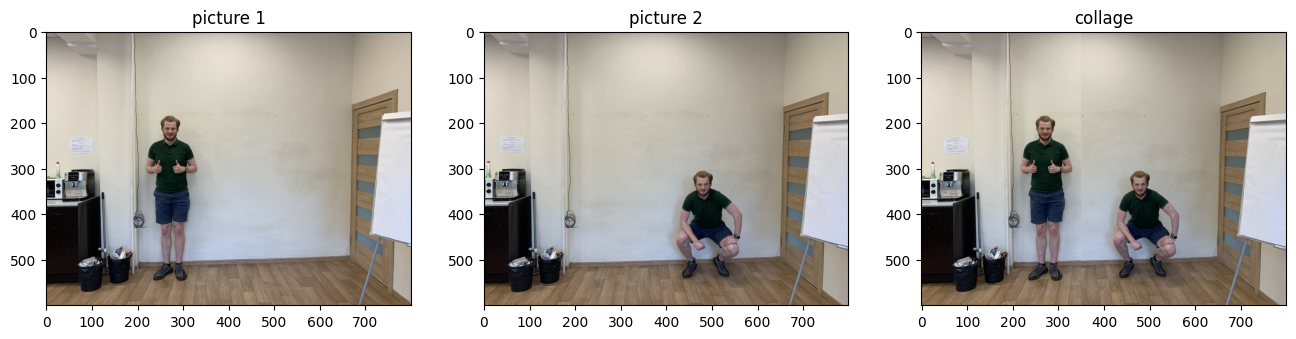

In [125]:
plot_pictures_collage(pictures, restored_picture)

In [141]:
bounds_1 = ((180, 550), (220, 340))
bounds_2 = ((300, 540), (420, 570))

DG, _ = create_graph(pictures[0].shape[:-1], pictures, bounds_1, bounds_2, neighbour_type="cross")

  0%|          | 0/480000 [00:00<?, ?it/s]

  0%|          | 0/480000 [00:00<?, ?it/s]

In [142]:
_, partition = nx.minimum_cut(DG, 's', 't')

In [143]:
restored_picture = make_restored_image(pictures[0].shape, partition)

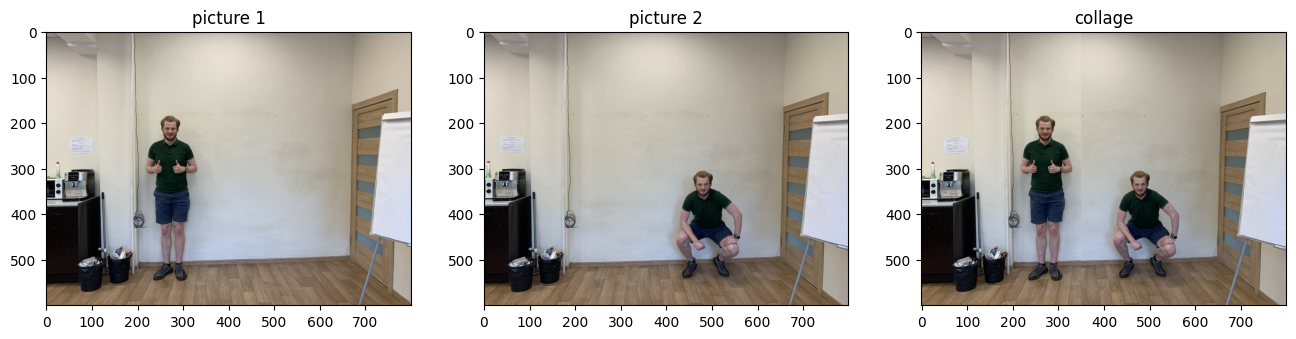

In [144]:
plot_pictures_collage(pictures, restored_picture)

In [130]:
bounds_1 = ((180, 550), (220, 340))
bounds_2 = ((300, 540), (420, 570))

DG, _ = create_graph(pictures[0].shape[:-1], pictures, bounds_1, bounds_2, binary=binary_tanh)

  0%|          | 0/480000 [00:00<?, ?it/s]

  0%|          | 0/480000 [00:00<?, ?it/s]

In [131]:
_, partition = nx.minimum_cut(DG, 's', 't')

In [132]:
restored_picture = make_restored_image(pictures[0].shape, partition)

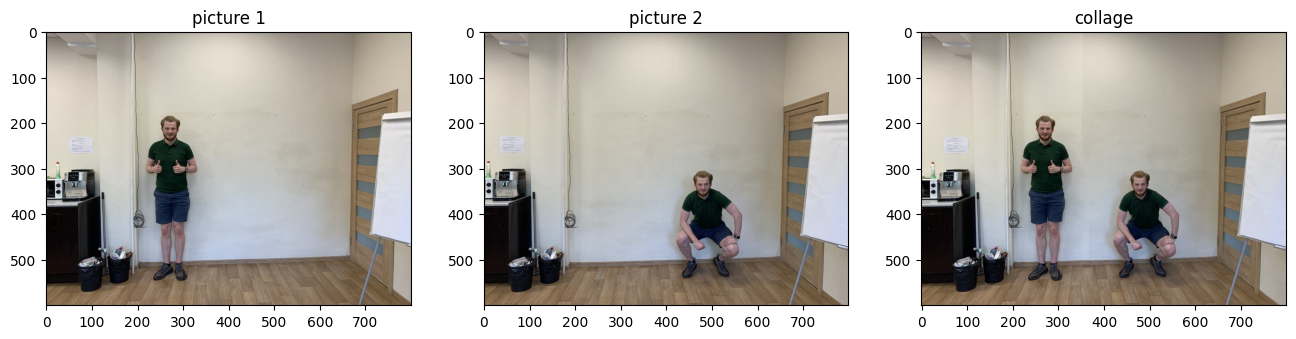

In [133]:
plot_pictures_collage(pictures, restored_picture)

In [137]:
bounds_1 = ((180, 550), (220, 340))
bounds_2 = ((300, 540), (420, 570))

DG, _ = create_graph(pictures[0].shape[:-1], pictures, bounds_1, bounds_2, binary=binary_tanh, neighbour_type="cross")

  0%|          | 0/480000 [00:00<?, ?it/s]

  0%|          | 0/480000 [00:00<?, ?it/s]

In [138]:
_, partition = nx.minimum_cut(DG, 's', 't')

In [139]:
restored_picture = make_restored_image(pictures[0].shape, partition)

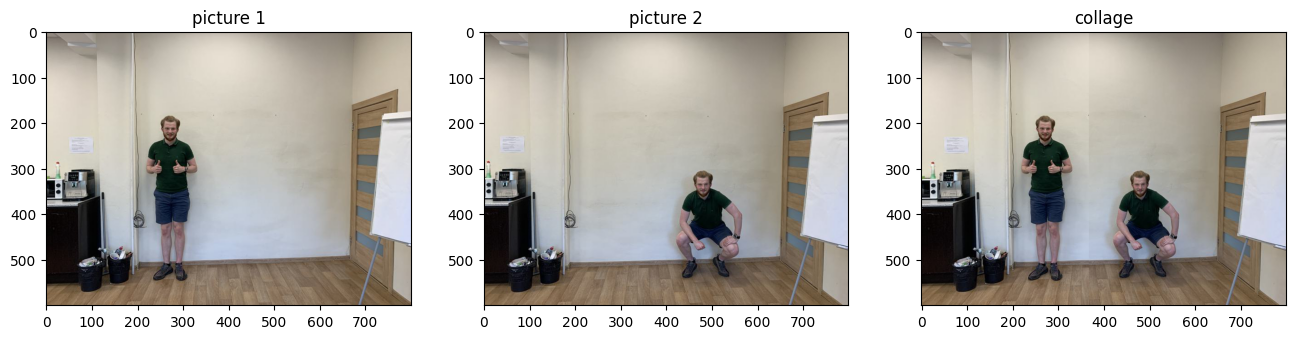

In [140]:
plot_pictures_collage(pictures, restored_picture)

Как мы видим, различий особо нет при использовании экспоненты или гиперболического тангенса в качестве парного потенциала, так же особо нет разницы при использовании вида соседства в виде креста или квадрата.

$\textbf{д)}$ Рассмотреть задачу построения коллажа с $K \geq 5$ изображениями. Выбрать парные потенциалы для построения реалистичного коллажа $θ_{ij}(x_i, xj)$, для которых одновременно выполнено $θ_{ij} (\alpha, \alpha) = 0$ $\forall \alpha$ и неравенство треугольника $θ_{ij} (\beta, \alpha) + θ_{ij} (\alpha, \gamma) \geq θ_{ij} (\beta, \gamma)$. (10 баллов)

Возьмем парный потенциал:

$$\theta_{ij}(x_i, x_j) = [x_i \neq x_j] \cdot \exp \left( \frac{ \|y_{x_i, i} - y_{x_j, j}\|_2}{2 \sigma^2} \right)$$

Для него верно: $θ_{ij} (\alpha, \alpha) = 0$ $\forall \alpha$

Покажем, что:

$$\exp \left( \frac{\|\beta - \alpha\|_2}{2 \sigma^2} \right) + \exp \left( \frac{\|\alpha - \gamma\|_2}{2 \sigma^2} \right) \geq \exp \left( \frac{\|\beta - \gamma\|_2}{2 \sigma^2} \right)$$

Накинем логарифм:

$$\ln \left( \exp \left( \frac{\|\beta - \alpha\|_2}{2 \sigma^2} \right) + \exp \left( \frac{\|\alpha - \gamma\|_2}{2 \sigma^2} \right) \right) \geq \frac{\|\beta - \gamma\|_2}{2 \sigma^2}$$

Для доказательства воспользуемся:

$$ \ln (\alpha x_1 + \beta x_2) \geq \alpha \ln (x_1) + \beta \ln (x_2)$$

Тогда:

$$\ln \frac{1}{2} + \ln \left( \exp \left( \frac{\|\beta - \alpha\|_2}{2 \sigma^2} \right) + \exp \left( \frac{ \|\alpha - \gamma\|_2}{2 \sigma^2} \right) \right) \geq \frac{1}{2} \left( \frac{\|\beta - \alpha\|_2}{2 \sigma^2} + \frac{\|\alpha - \gamma\|_2}{2 \sigma^2}\right)$$

То есть надо показать, что:

$$\ln 2 + \frac{1}{2} \left( \frac{\|\beta - \alpha\|_2}{2 \sigma^2} + \frac{\|\alpha - \gamma\|_2}{2 \sigma^2}\right) \geq \frac{\|\beta - \gamma\|_2}{2 \sigma^2}$$

Или можно показать:

$$\ln 2 +  \frac{\|\beta - \gamma\|_2}{4 \sigma^2} \geq \frac{\|\beta - \gamma\|_2}{2 \sigma^2}$$

Или:

$$\ln 2 \geq \frac{\|\beta - \gamma\|_2}{4 \sigma^2}$$

Также мы знаем, что норма ограничена $\sqrt{3}$, тогда:

$$\sigma^2 \geq \frac{\sqrt{3}}{4 \ln 2}$$

А сигму мы можем выбрать, поэтому неравенство будет верным.

$\textbf{е)}$ 
1. Реализовать алгоритм $\alpha$-расширения для приближенного поиска наиболее вероятной конфигурации $\textbf{x}^*$ в графической модели, заданной выбранной энергией $E(x)$:

$$\textbf{x}^* = \arg \min E(x) = \arg \min \sum_i θ_i (x_i) + \sum_{(i, j) \in \varepsilon} θ_{ij} (x_i, x_j).\ \text{(35 баллов)}$$

2. Можно ли было использовать алгоритм $\alpha$-расширения для парных потенциалов, для которых выполнено $θ_{ij} (\alpha, \alpha) = 0$ $\forall \alpha$, но не выполнено неравенство треугольника? (5 баллов)

1. $ $

2. При таком условии использовать алгоритм $\alpha$-расширения можно, но не будет гарантии на то, что алгоритм будет работать за полиномиальное время, он может застрять в локальном минимуме.

$\textbf{ж)}$ Попробовать построить коллаж из нескольких наборов изображений, пробуя модифицировать потенциалы для улучшения коллажа. Привести описание попыток, промежуточные результаты и лучший получившийся коллаж. Автор лучшего коллажа получит дополнительные баллы. (25 баллов)

$\textbf{з)}$ 
1. Сформулировать задачу сегментации изображений в вероятностом смысле. (5 баллов)

2. Попробовать реализованные алгоритмы для решения этой задачи на открытых наборах данных. (20 баллов)

1. Хотим восстановить скрытые состояния каждого пикселя $\textbf{x}$, для этого:

   Решается задача оптимизации:

   $$ p(\mathbf{x}|\mathbf{y}) \to \max_{\mathbf{x}} \equiv p(\mathbf{x}, \mathbf{y}) \to \max_{\mathbf{x}}$$

   $p(\mathbf{x}, \mathbf{y})$ представима в виде:
   
   $$ p(\mathbf{x}, \mathbf{y}) = \psi_0 \prod_{(i, j) \in \varepsilon} \psi_{ij}(x_i, x_j) \prod_{i} \psi_{i}(x_i, y_i)$$
   
   Можно ввести энергию, таким образом:
   
   $$ p(\mathbf{x}, \mathbf{y}) = \frac{1}{Z} e^{-E(\mathbf{x}, \mathbf{y})},\ \text{где}\ Z - \text{нормировочная константа} $$
   
   И переписать ее так:
   
   $$ E(\mathbf{x}, \mathbf{y}) = - \log \psi_0 - \sum_{(i, j) \in \varepsilon} \log \psi_{ij}(x_i, x_j) - \sum_{i} \log \psi_{i}(x_i, y_i) + Сonst$$
    
   Тогда задачу оптимизации можно переписать в виде:
   
   $$ E(\mathbf{x}, \mathbf{y}) \to \min_{\mathbf{x}} \equiv \tilde{E}(\mathbf{x}) = \theta_0 + \sum_i \theta_i(x_i) + \sum_{(i, j) \in \varepsilon} \theta_{ij}(x_i, x_j) \to \min_{\mathbf{x}}$$

2. $ $

$\textbf{и)}$
1. Проведите оценку качества работы алгоритма вывода с выбранными потенциалами. (5 баллов)

2. Модифицируйте потенциалы, использованные при построении коллажа, чтобы лучше соответствовать задаче сегментации / восстановления стерео изображения и проверьте качество работы алгоритма. (20 баллов)

$\textbf{к)}$
1. Сравните достигнутое качество работы с одним из бенчмарков для соответствующей задачи по выбору. (10 баллов). 

2. Что позволяет выбранным вами потенциалам и вероятностной модели / бенчмарку работать лучше на рассмотренной выборке? (10 баллов)